# Statistical Methods for Machine Learning project

In [1]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform, util
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, models, datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import copy
from PIL import Image
import pdb
import random
import numpy.random as npr

import math
import kagglehub
import shutil

random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


cuda:0


In [2]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 50.4 MB/s eta 0:00:00


# Creation of training and test folders

In [3]:
if not os.path.exists('train'):
    # Download latest version
    path = kagglehub.dataset_download("drgfreeman/rockpaperscissors")
    print("Path to dataset files:", path)

    # creation of training and test folders
    ratio = 0.8
    subfolders = ['rock','paper','scissors']

    os.makedirs('train', exist_ok=True)
    os.makedirs('test', exist_ok=True)
    for subfolder in subfolders:
        subpath = os.path.join(path, subfolder)
        os.makedirs(os.path.join('train',subfolder))
        os.makedirs(os.path.join('test',subfolder))

        imgs = os.listdir(subpath)
        random.shuffle(imgs)

        train_size = int(0.8 * len(imgs))
        test_size = len(imgs) - train_size

        train_imgs = imgs[:train_size]
        test_imgs = imgs[train_size:]

        for i in train_imgs:
            shutil.copy(os.path.join(subpath,i), os.path.join('train',subfolder,i))
        for i in test_imgs:
            shutil.copy(os.path.join(subpath,i), os.path.join('test',subfolder,i))




Using Colab cache for faster access to the 'rockpaperscissors' dataset.
Path to dataset files: /kaggle/input/rockpaperscissors


(200, 300, 3)


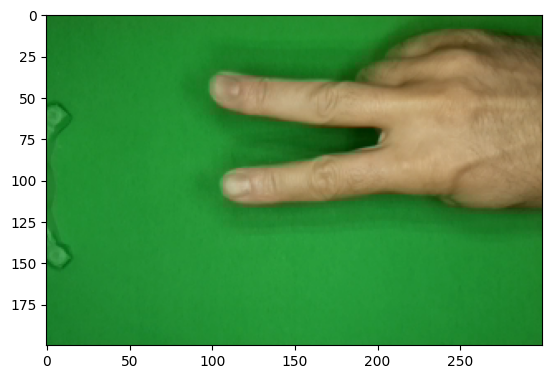

In [4]:
plt.figure()
folder = os.path.join('train', random.choice(['rock','paper','scissors']))
img_name = random.choice(os.listdir(folder))
img = io.imread(os.path.join(folder,img_name))
print( img.shape)
plt.imshow(img)
plt.show()

# Transformation and data augmentation

In [5]:
# no need to resize since all images have the same dimension (?)
# test set only transformed to tensor
# training set augmented with random transformations

test_transform = transforms.Compose([
    transforms.ToTensor()
])
train_transform = transforms.Compose([
    transforms.ToTensor(),
    #transforms.RandomRotation(degrees=(-20,20)),
])

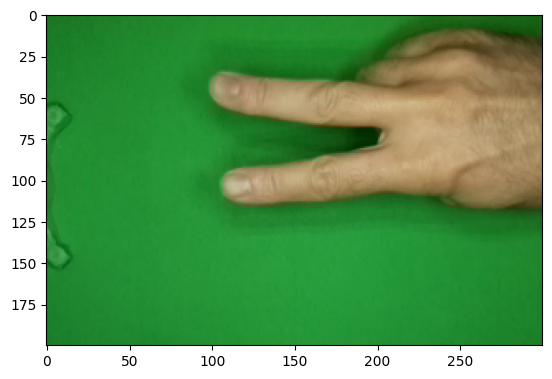

In [6]:
transformed_img = train_transform(img)
plt.imshow(transformed_img.permute(1,2,0))
plt.show()

# DataLoader creation

In [7]:
batch_size = 9
train_dataset = datasets.ImageFolder(root='train', transform=train_transform)
test_dataset = datasets.ImageFolder(root='test', transform=test_transform)

train_dl = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dl = DataLoader(test_dataset, batch_size=batch_size)

classes = train_dataset.classes

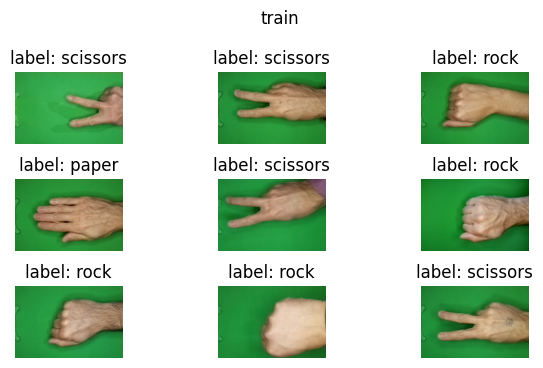

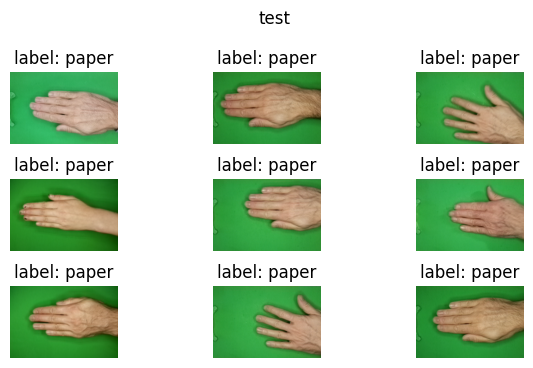

In [8]:
def show_batch(x, y, yh=None, title=None):
    col = math.floor(math.sqrt(len(x)))
    row = col+1
    for i in range(len(x)):
        ax = plt.subplot(row,col,i+1)
        plt.tight_layout()
        subtitle = 'label: ' + classes[int(y[i])]
        if (yh is not None):
            subtitle += '\nprediction: ' + classes[int(np.argmax(yh[i]))]
        ax.set_title(subtitle)
        ax.axis('off')
        plt.imshow(x[i].permute(1,2,0))
    if (title):
        plt.subplots_adjust(top=0.85)
        plt.suptitle(title)
    plt.show()

show_batch(*next(iter(train_dl)), title='train')
show_batch(*next(iter(test_dl)), title='test')

# Training function

In [9]:
from tqdm import tqdm
import torchmetrics
from torchmetrics import Accuracy, Precision, Recall

def train_model(model, dataloaders,  criterion, optimizer, scheduler, num_epochs=25):
    stats = {
            'train_loss': [],
            'test_loss': [],
            'test_acc': [],
            'test_rec': [],
            'test_prec': []
    }
    for epoch in range(num_epochs):

        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-'*10)

        # TRAIN
        running_loss = 0
        for batch_index, (images, labels) in enumerate(tqdm(dataloaders['train'])):
            optimizer.zero_grad()
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            running_loss += loss.item()*images.size(0)
            optimizer.step()

        epoch_loss = running_loss / len(dataloaders['train'])
        stats['train_loss'].append(epoch_loss)

        # test
        acc = Accuracy(task="multiclass",num_classes=len(classes)).to(device)
        precision = Precision(task="multiclass", num_classes=len(classes), average='macro').to(device)
        recall = Recall(task="multiclass", num_classes=len(classes), average='macro').to(device)

        model.eval()
        with torch.no_grad():
            for images, labels in dataloaders['test']:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                running_loss += loss.item()*images.size(0)
                _, preds = torch.max(outputs, 1)
                acc(preds, labels)
                precision(preds, labels)
                recall(preds, labels)

            test_loss = running_loss / len(dataloaders['test'])
            test_accuracy = acc.compute()
            test_precision = precision.compute()
            test_recall = recall.compute()

            stats['test_loss'].append(test_loss)
            stats['test_acc'].append(test_accuracy.to('cpu'))
            stats['test_rec'].append(test_recall.to('cpu'))
            stats['test_prec'].append(test_precision.to('cpu'))


        print(f"Train loss: {epoch_loss:.4f}")
        print(f"Test loss: {test_loss:.4f}")
        print(f"Test accuracy: {test_accuracy:.4f}")
        print(f"Test precision: {test_precision:.4f}")
        print(f"Test recall: {test_recall:.4f}")

    plt.plot(stats['train_loss'], 'bo-', label='train loss')
    plt.plot(stats['test_loss'], 'r+-', label='test loss')
    plt.show()

    plt.plot(stats['test_acc'])
    plt.plot(stats['test_rec'])
    plt.plot(stats['test_prec'])
    plt.show()

# Graph function

In [10]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def cm_plot(model, dl):
    y = []
    y_hat = []
    classes = dl.dataset.classes

    with torch.set_grad_enabled(False):
        for img, lbls in dl:
            output = net(img.to(device).float()).to('cpu').float()
            y.extend(lbls)
            pred = output.data.max(1, keepdim=True)[1]
            y_hat.extend(pred)

    cm = confusion_matrix(y, y_hat, labels=range(len(classes)))
    ConfusionMatrixDisplay(cm,display_labels=classes).plot()

In [41]:
def show_misclassified(model, dl):
    wrong = []
    classes = dl.dataset.classes

    with torch.set_grad_enabled(False):
        for img, lbls in dl:
            output = net(img.to(device).float()).to('cpu').float()
            pred = output.data.max(1, keepdim=True)[1]
            zipped = list(zip(img,lbls,pred))
            for z in zipped:
                if (int(z[1]) != int(z[2])):
                    wrong.append(z)
    x,y,yh = zip(*wrong)
    for i in range(len(x)):
        plt.title('label: ' + classes[int(y[i])] + '\nprediction: ' + classes[int(yh[i])])
        plt.axis('off')
        plt.imshow(x[i].permute(1,2,0))
        plt.show()
    #show_batch(list(x),list(y),list(yh), title='wrong predictions')

# Network definition

In [13]:
# Simple net
class SimpleNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16,kernel_size=3,stride=1,padding=1)
        self.conv2 = nn.Conv2d(16,32,kernel_size=3,stride=1,padding=1)
        self.pool = nn.MaxPool2d(2,2)

        self.fc1 = nn.Linear(32*50*75,128)
        self.fc2 = nn.Linear(128,3)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.flatten(start_dim=1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


# Experiments

Epoch 0/9
----------


100%|██████████| 195/195 [00:08<00:00, 24.28it/s]


Train loss: 6.8051
Test loss: 32.6333
Test accuracy: 0.7472
Test precision: 0.8110
Test recall: 0.7505
Epoch 1/9
----------


100%|██████████| 195/195 [00:07<00:00, 25.35it/s]


Train loss: 3.1563
Test loss: 15.2162
Test accuracy: 0.9203
Test precision: 0.9219
Test recall: 0.9200
Epoch 2/9
----------


100%|██████████| 195/195 [00:06<00:00, 28.74it/s]


Train loss: 2.0005
Test loss: 10.4210
Test accuracy: 0.9294
Test precision: 0.9314
Test recall: 0.9292
Epoch 3/9
----------


100%|██████████| 195/195 [00:06<00:00, 30.59it/s]


Train loss: 1.3729
Test loss: 7.6433
Test accuracy: 0.9362
Test precision: 0.9374
Test recall: 0.9356
Epoch 4/9
----------


100%|██████████| 195/195 [00:06<00:00, 28.66it/s]


Train loss: 1.0434
Test loss: 6.7498
Test accuracy: 0.9431
Test precision: 0.9458
Test recall: 0.9423
Epoch 5/9
----------


100%|██████████| 195/195 [00:06<00:00, 28.52it/s]


Train loss: 0.5454
Test loss: 4.7726
Test accuracy: 0.9544
Test precision: 0.9554
Test recall: 0.9540
Epoch 6/9
----------


100%|██████████| 195/195 [00:06<00:00, 29.65it/s]


Train loss: 0.3339
Test loss: 3.7687
Test accuracy: 0.9544
Test precision: 0.9545
Test recall: 0.9543
Epoch 7/9
----------


100%|██████████| 195/195 [00:06<00:00, 28.14it/s]


Train loss: 0.3117
Test loss: 3.5414
Test accuracy: 0.9431
Test precision: 0.9430
Test recall: 0.9431
Epoch 8/9
----------


100%|██████████| 195/195 [00:06<00:00, 28.95it/s]


Train loss: 0.3040
Test loss: 3.8354
Test accuracy: 0.9431
Test precision: 0.9464
Test recall: 0.9423
Epoch 9/9
----------


100%|██████████| 195/195 [00:06<00:00, 30.64it/s]


Train loss: 0.1660
Test loss: 3.6191
Test accuracy: 0.9385
Test precision: 0.9411
Test recall: 0.9387


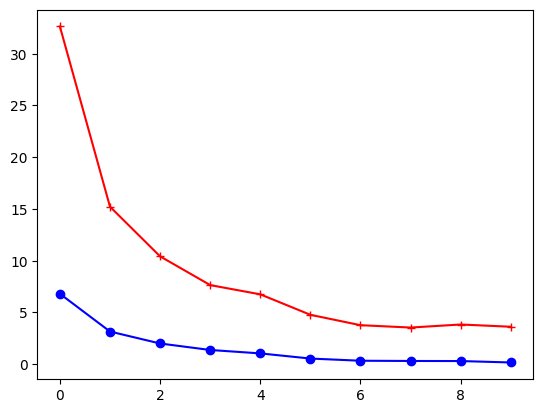

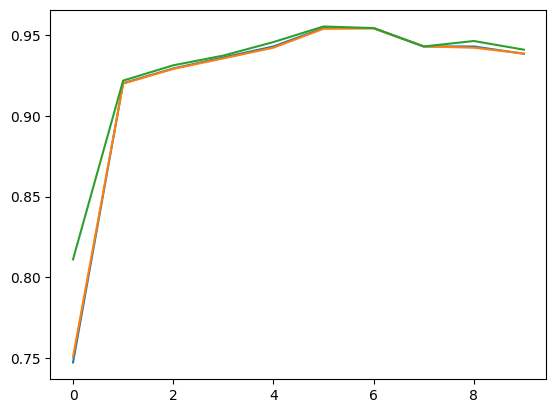

In [14]:
net = SimpleNet()
net.to(device)
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.Adam(net.parameters(), lr=1e-3)
# An lr strategy which decreases lr by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)


image_datasets = {'train' : train_dataset, 'test': test_dataset}

dls = {'train' : train_dl, 'test': test_dl}

dataset_sizes = {'train': len(train_dataset), 'test': len(test_dataset)}
train_model(net, dls, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=10)

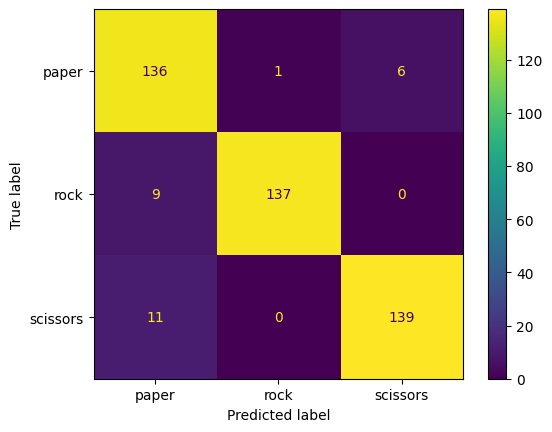

In [15]:
cm_plot(net, test_dl)

Size of tensor containing a batch of images is torch.Size([9, 3, 200, 300])


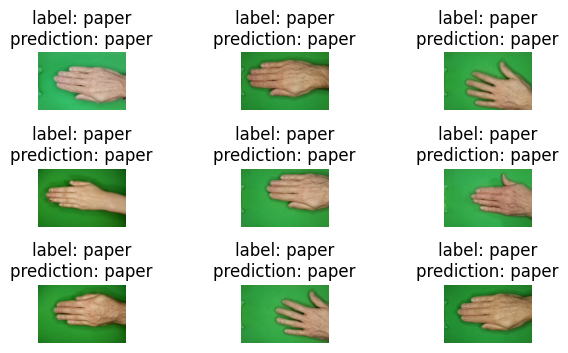

In [32]:
img,lbl=next(iter(test_dl))
inputs = img.to(device).float()
labels = lbl.to(device).float()

print('Size of tensor containing a batch of images is {}'.format(inputs.shape))

with torch.set_grad_enabled(False):
    outputs = net(inputs)


if (device=='cpu'):
    show_batch(img,lbl,outputs)
else:
    show_batch(img,lbl,outputs.cpu().numpy())



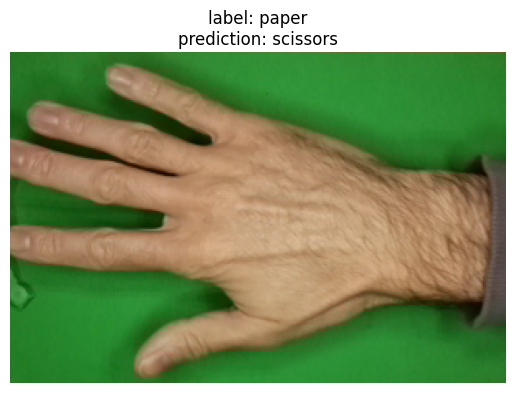

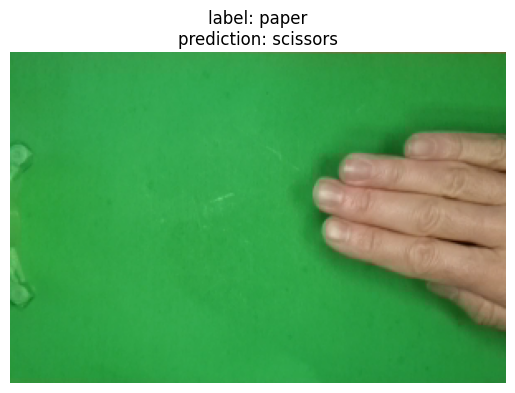

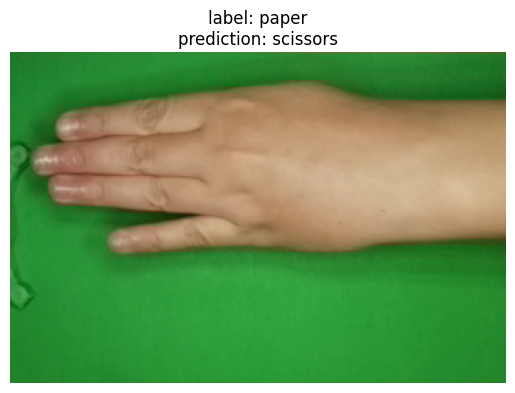

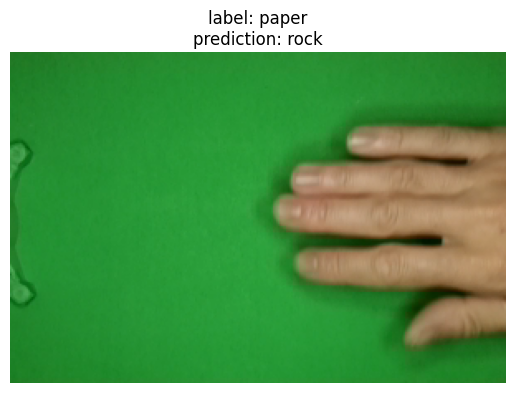

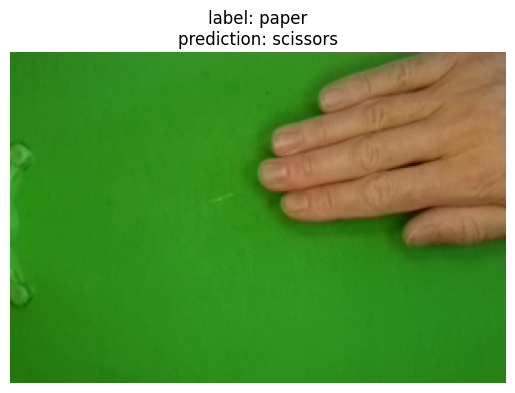

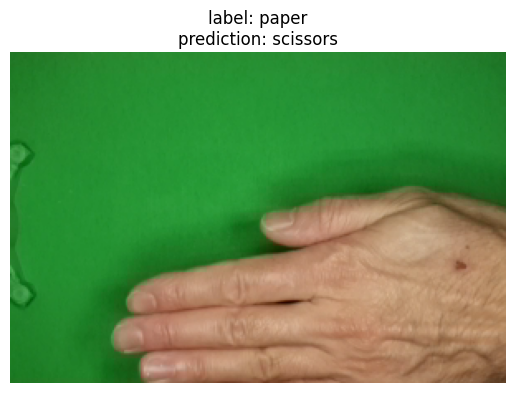

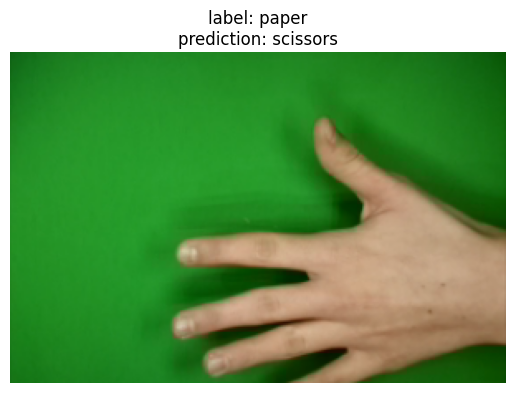

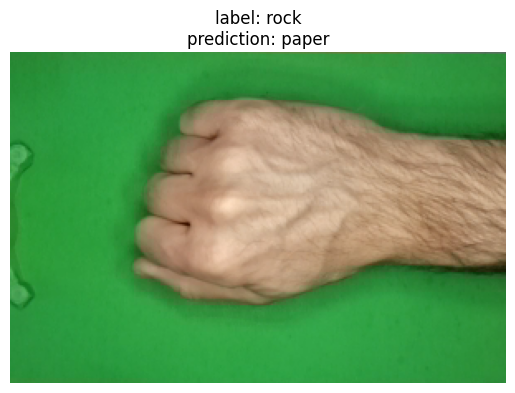

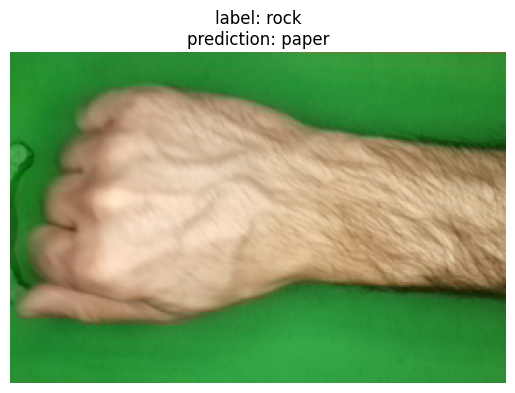

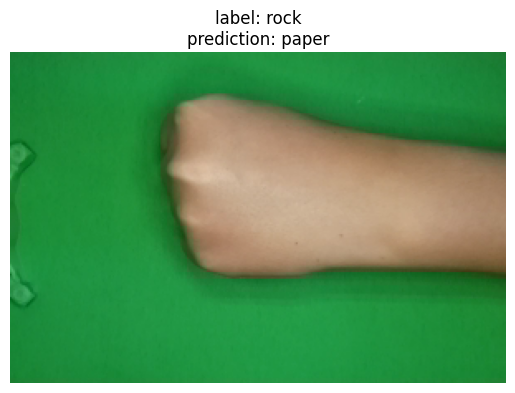

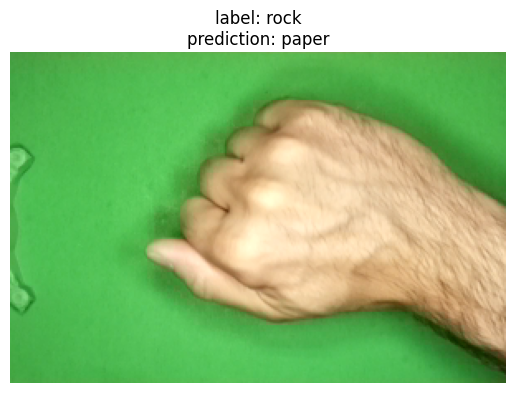

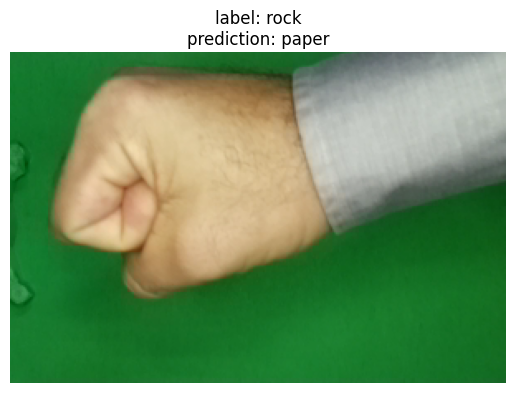

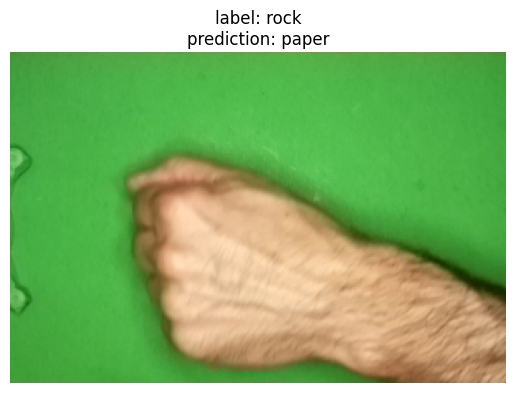

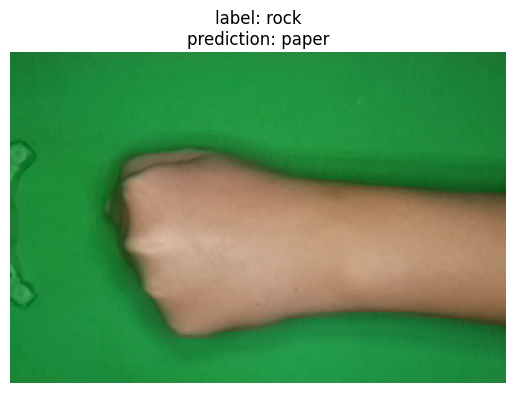

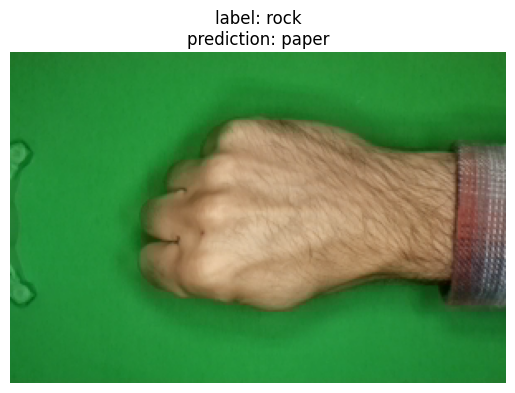

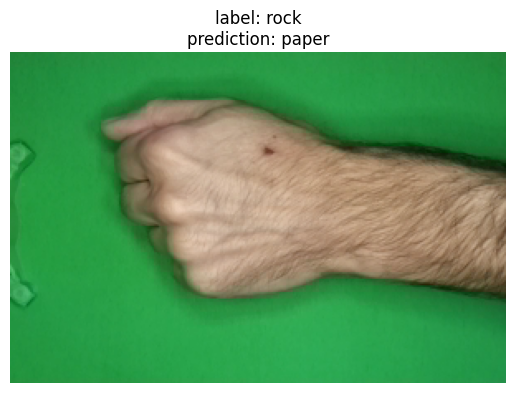

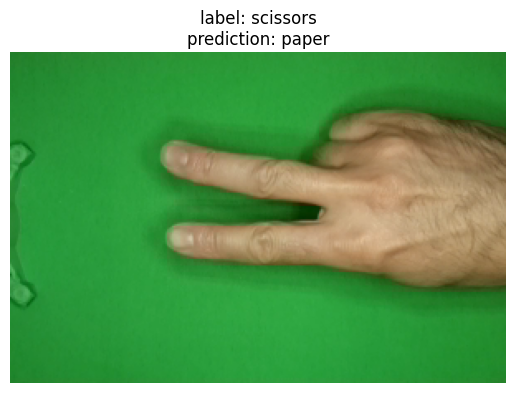

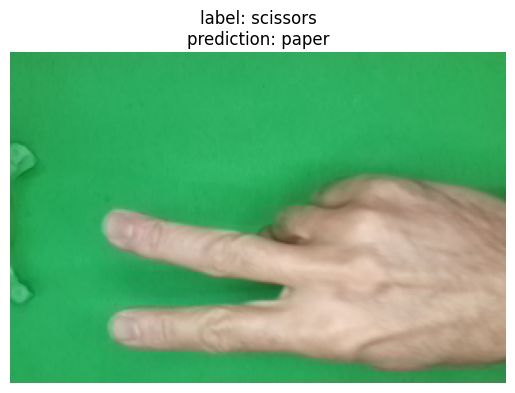

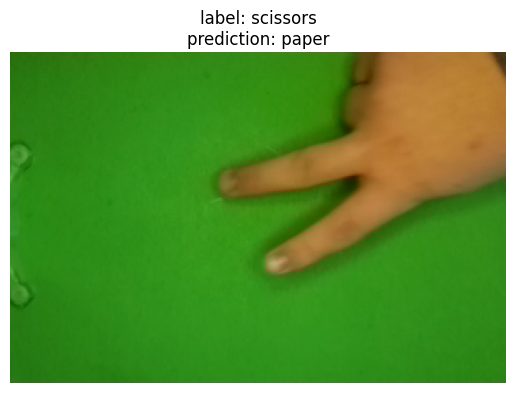

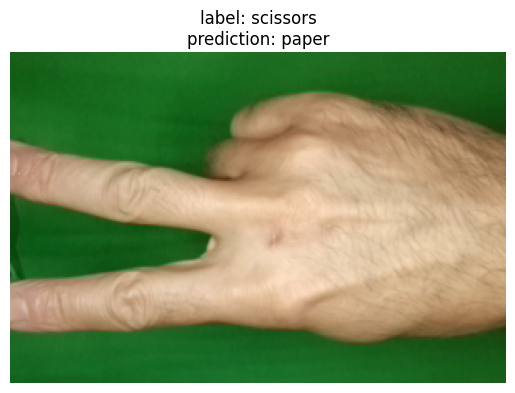

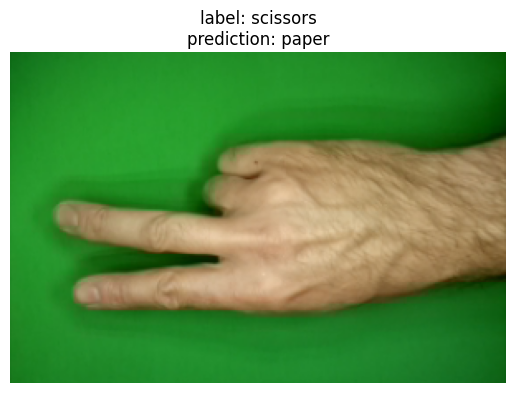

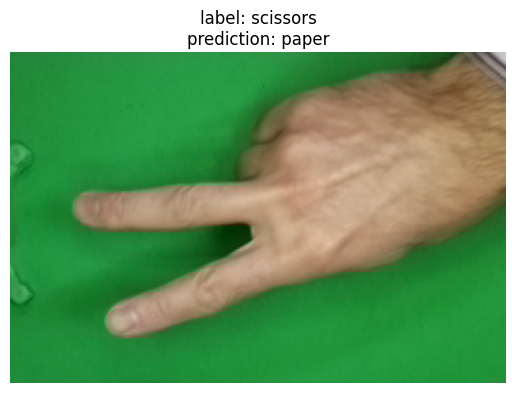

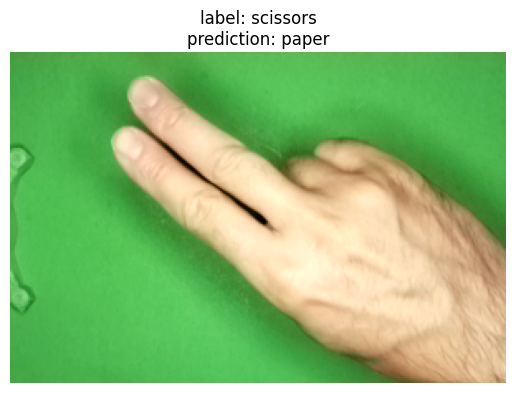

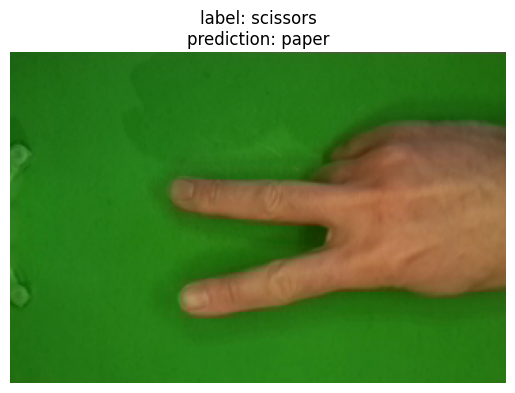

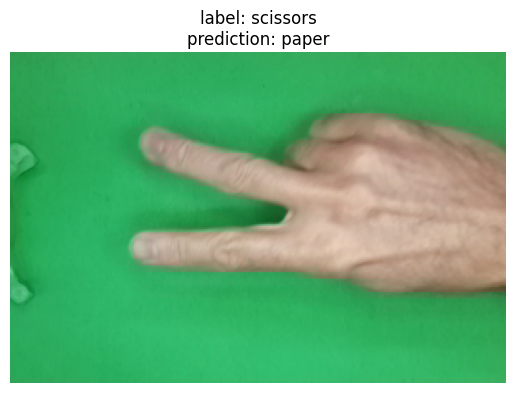

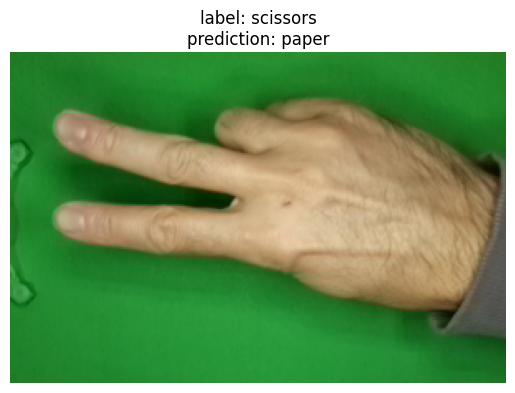

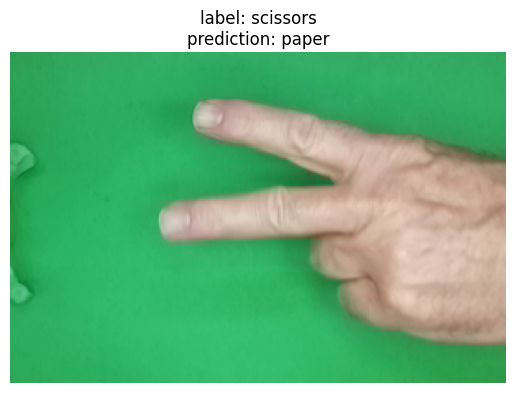

In [42]:
show_misclassified(net, test_dl)